# Spatial Target Cells

Analyses for if cells care about the spatial target.

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import (compute_nbins, compute_occupancy, compute_spatial_bin_edges,
                                          compute_spatial_bin_assignment, compute_bin_time)
from spiketools.spatial.utils import get_pos_ranges, get_bin_width
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import (zscore_to_surrogates, compute_empirical_pvalue, 
                                           compute_surrogate_stats)
from spiketools.plts.space import plot_positions, plot_heatmap
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import color_pval
from spiketools.utils import restrict_range, get_value_by_time, get_value_by_time_range, set_random_seed
from spiketools.utils.trials import epoch_data_by_range, epoch_spikes_by_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions, compute_bin_firing
from target import compute_spatial_target_bins, get_trial_target

In [5]:
from functools import partial
from spiketools.stats.anova import create_dataframe, fit_anova
create_df_target = partial(create_dataframe, columns=['target_bin', 'fr'])
fit_anova_target = partial(fit_anova, formula='fr ~ C(target_bin)', feature='C(target_bin)')

## Settings

In [6]:
# Set random seed, for consistency shuffling
set_random_seed(101)

In [7]:
# Define the base data folder
#data_folder = Path('/Users/Claire_han/Documents/Data/JacobsLab/TH')
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [8]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [9]:
# Define binning for chests (spatial target)
chest_bins = [6, 8]
n_bins = chest_bins[0] * chest_bins[1]

# Define minimum required occupancy (in seconds)
min_occ = 1

In [10]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'  # 'CIRCULAR', 'BINCIRC'
n_surrogates = 100

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {'shuffle_min' : 20000}

In [11]:
# Set example unit to analyze
uind = 36

## Load Data

In [12]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [13]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

#### Get Trial Data


In [14]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [15]:
# Extract behavioural markers of interest
nav_starts = nwbfile.trials['navigation_start'].data[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

#### Extract Spike Data

In [16]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [17]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

#### Extract Position Data

In [18]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [19]:
# Get the chest positions & trial indices
chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T
chest_trials = nwbfile.trials.chest_trials[:]

## Chest Positions

In [20]:
# Check chest position range
print('Chest X position range: {:1.2f} - {:1.2f}'.format(np.min(chest_xs), np.max(chest_xs)))
print('Chest Y position range: {:1.2f} - {:1.2f}'.format(np.min(chest_ys), np.max(chest_ys)))

Chest X position range: 362.86 - 406.85
Chest Y position range: 321.34 - 396.47


In [21]:
# Check traversal position range
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[0, :]), np.max(positions[0, :])))
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[1, :]), np.max(positions[1, :])))

Position X range: 365.40 - 404.59
Position X range: 285.00 - 433.00


In [22]:
# Select the position values for navigation periods
_, positions_trials = epoch_data_by_range(ptimes, positions,
                                          nwbfile.trials.navigation_start[:],
                                          nwbfile.trials.navigation_stop[:])

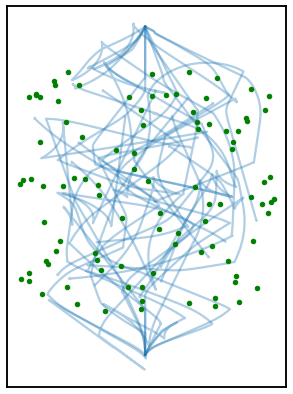

In [23]:
# Plot the subject positions, overlaid with chest positions
plot_positions(positions_trials, figsize=(5, 7))
plt.gca().plot(chest_xs, chest_ys, '.g')# Compute edges for chest binning

In [24]:
# Compute edges for chest binning
area_range = [[360, 410], [320, 400]]
x_edges, y_edges = compute_spatial_bin_edges(positions, chest_bins, area_range=area_range)

In [25]:
# Assign each chest to a bin
chest_pos = np.array([chest_xs, chest_ys])
ch_xbin, ch_ybin = compute_spatial_bin_assignment(chest_pos, x_edges, y_edges)

# Fix offset of chest binning
ch_xbin = ch_xbin - 1 
ch_ybin = ch_ybin - 1 

## Single Trial

In [26]:
# Get trial information
t_ind = 10

t_st = nwbfile.trials['navigation_start'][t_ind]
ch_openings = nwbfile.trials['chest_opening_time'][t_ind]
t_en = ch_openings[-1]

In [27]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [28]:
# Select chest openings for the current trial
t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [29]:
# Restrict spikes to the start of nav and the end of chest opening
t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

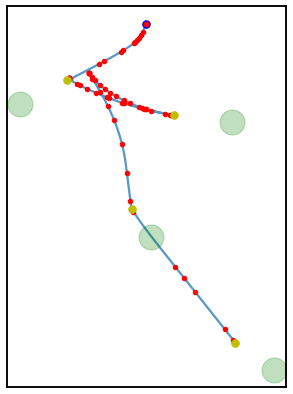

In [30]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
plot_positions(t_pos, alpha=0.75, figsize=(5, 7))
ax = plt.gca()
ax.plot(*t_pos[:, 0], 'b.', ms=15)
ax.plot(t_spike_xs, t_spike_ys, '.r')
[ax.plot(*cht, 'y.', ms=15) for cht in ch_times];
ax.plot(chest_xs[t_mask], chest_ys[t_mask], '.g', ms=50, alpha=0.25)

## Spatial Target Bins

In [31]:
# Compute chest occupancy
chest_occupancy = compute_bin_firing(ch_xbin, ch_ybin, chest_bins)

In [32]:
# Check the number of chests per bin
print("Range of chests per bin: {:1.0f} - {:1.0f}".format(\
    np.min(chest_occupancy), np.max(chest_occupancy)))

Range of chests per bin: 0 - 5


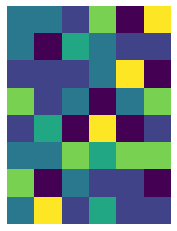

In [33]:
# Plot chest occupancy
plot_heatmap(chest_occupancy, transpose=True)

In [34]:
# Collect firing per chest location across all trials
target_bins = compute_spatial_target_bins(spikes, nav_starts, chest_openings, chest_trials, 
                                          ptimes, positions, chest_bins, ch_xbin, ch_ybin)

In [35]:
# Check range of firing across spatial target bins
np.min(target_bins), np.max(target_bins)

(0.0, 23.715288894873463)

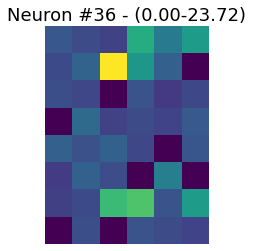

In [36]:
# Check the firing rate per spatial destination for an example neuron
plot_heatmap(target_bins, transpose=True,
             title='Neuron #{} - ({:1.2f}-{:1.2f})'.format(uind, np.min(target_bins), np.max(target_bins)))

# ANOVA TEST

### Use fr ~ C(target_bin), real data

#### Single Trial

In [37]:
# OLD
# Collect firing per chest location for one selected trial
target_bins = np.zeros(chest_bins)

t_ind = 6
t_st = nav_starts[t_ind]
ch_openings = chest_openings[t_ind]
t_en = ch_openings[-1]

t_mask = chest_trials == t_ind

t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
count.update(np.digitize(t_spikes, ch_openings))

frs = np.array(list(count.values())) / seg_times

cur_ch_xbin = ch_xbin[t_mask]
cur_ch_ybin = ch_ybin[t_mask]

for fr, xbin, ybin in zip(frs, cur_ch_xbin, cur_ch_ybin):
    target_bins[xbin, ybin] = fr

In [38]:
# OLD
# Collect firing per chest location for each trial
target_bins_1d = np.zeros([n_trials, n_bins])
for t_ind in range(n_trials):
    
    # Get trial information
    t_st = nav_starts[t_ind]
    ch_openings = chest_openings[t_ind]
    t_en = ch_openings[-1]

    t_mask = chest_trials == t_ind
    
    # Select chest openings for the current trial
    t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
    ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]
    
    # Restrict spikes to the chest-opening period
    t_spikes = restrict_range(spikes, t_st, t_en)
    t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)
    
    # compute firing rate per bin per trial
    seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
    count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
    count.update(np.digitize(t_spikes, ch_openings))

    frs = np.array(list(count.values())) / seg_times

    cur_ch_xbin = ch_xbin[t_mask]
    cur_ch_ybin = ch_ybin[t_mask]
    
    target_bins = np.zeros(chest_bins)
    for fr, xbin, ybin in zip(frs, cur_ch_xbin, cur_ch_ybin):
        target_bins[xbin, ybin] = fr
        
    target_bins_1d[t_ind,:] = target_bins.flatten()

In [39]:
# OLD
# create the bin label
target_bins_trial = target_bins_1d.flatten()
target_bin_label = np.array(range(0, n_bins))
target_bin_label = np.tile(target_bin_label,n_trials)

# create the dataframe for ANOVA
merged_array = np.transpose(np.vstack([target_bin_label, target_bins_trial]))
df = pd.DataFrame(merged_array, columns=['target_bin', 'fr'])

In [40]:
df.head(10)

,target_bin,fr
0,0.0,0.000000
1,1.0,8.527265
2,2.0,0.000000
3,3.0,0.000000
4,4.0,0.000000
5,5.0,0.000000
6,6.0,13.692304
7,7.0,0.000000
8,8.0,0.000000
9,9.0,0.000000


In [41]:
# OLD
# build the ANOVA model
model = smf.ols('fr ~ C(target_bin)', data=df).fit()
aov_table = anova_lm(model, typ=2)
#print(aov_table)

# get the F-value from ANOVA model
f_val = aov_table['F']['C(target_bin)']
print(f_val)

#model.summary()

1.5333053630663758


In [42]:
# Get the target related firing per trial
target_trial = get_trial_target(spikes, nav_starts, chest_bins, chest_openings,
                                chest_trials, ch_xbin, ch_ybin, ptimes, positions)

In [43]:
# Create the dataframe
df = create_df_target(target_trial)

In [44]:
df.head(10)

,target_bin,fr
0,0.0,0.000000
1,1.0,8.527265
2,2.0,0.000000
3,3.0,0.000000
4,4.0,0.000000
5,5.0,0.000000
6,6.0,13.692304
7,7.0,0.000000
8,8.0,0.000000
9,9.0,0.000000


In [45]:
# Fit the ANOVA, and get the f-value
f_val = fit_anova_target(df)
f_val

1.5333053630663758

# ANOVA Surrogate

### fr ~ C(target_bin), 100 surrogates

In [46]:
# Create shuffles
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

In [47]:
# OLD
# get firing rate per bin, per trial, for shuffled data
surrogates = []
for i, j in enumerate(times_shuffle):
    target_bins_1d = np.zeros([n_trials, n_bins])
    
    for t_ind in range(n_trials):
        t_st = nav_starts[t_ind]
        ch_openings = chest_openings[t_ind]
        t_en = ch_openings[-1]

        t_mask = chest_trials == t_ind

        t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
        ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

        t_spikes = restrict_range(times_shuffle[i], t_st, t_en)
        t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

        seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
        count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
        count.update(np.digitize(t_spikes, ch_openings))

        frs = np.array(list(count.values())) / seg_times

        cur_ch_xbin = ch_xbin[t_mask]
        cur_ch_ybin = ch_ybin[t_mask]

        target_bins = np.zeros(chest_bins)
        for fr, xbin, ybin in zip(frs, cur_ch_xbin, cur_ch_ybin):
            target_bins[xbin, ybin] = fr

        target_bins_1d[t_ind,:] = target_bins.flatten()
        
    target_bins_trial=target_bins_1d.flatten()

    target_bin_label = np.array(range(0, n_bins))
    target_bin_label = np.tile(target_bin_label,n_trials)

    merged_array = np.transpose(np.vstack([target_bin_label,target_bins_trial]))
    df = pd.DataFrame(merged_array,columns=['target_bin', 'fr'])
    
    model = smf.ols('fr ~ C(target_bin)', data=df).fit()
    aov_table = anova_lm(model, typ=2)
    f_val_surrs = aov_table['F']['C(target_bin)']
    
    surrogates.append(f_val_surrs)

p-value: 0.00
z-score: 2.13


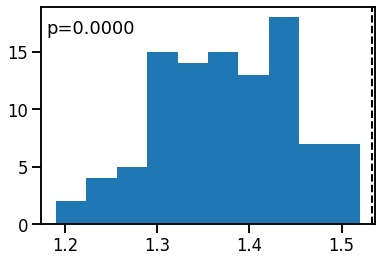

In [48]:
# OLD
# Compute the empirical p-value based on surrogates
surr_p_val = compute_empirical_pvalue(f_val, surrogates)

# Compute z-score of the real F-value compared to surrogates
z_score = zscore_to_surrogates(f_val, surrogates)

# Print out the compute p-value and z-scored information
print('p-value: {:4.2f}'.format(surr_p_val))
print('z-score: {:4.2f}'.format(z_score))

# Plot the distribution of surrogates, comparing to real F-value
plot_surrogates(surrogates, f_val, surr_p_val)

In [49]:
# NEW

In [50]:
# Compute measures on surrogates
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    
    data = get_trial_target(shuffle, nav_starts, chest_bins, chest_openings,
                            chest_trials, ch_xbin, ch_ybin, ptimes, positions)
    df = create_df_target(data)
    surrogates[ind] = fit_anova_target(df)

p-value: 0.00
z-score: 2.13


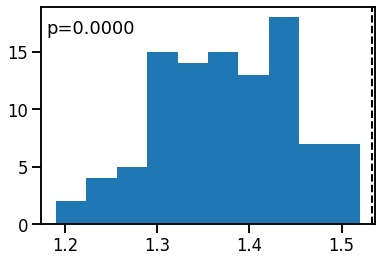

In [51]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(f_val, surrogates)

## All Cells

In [52]:
n_surrogates = 10
set_random_seed(101)

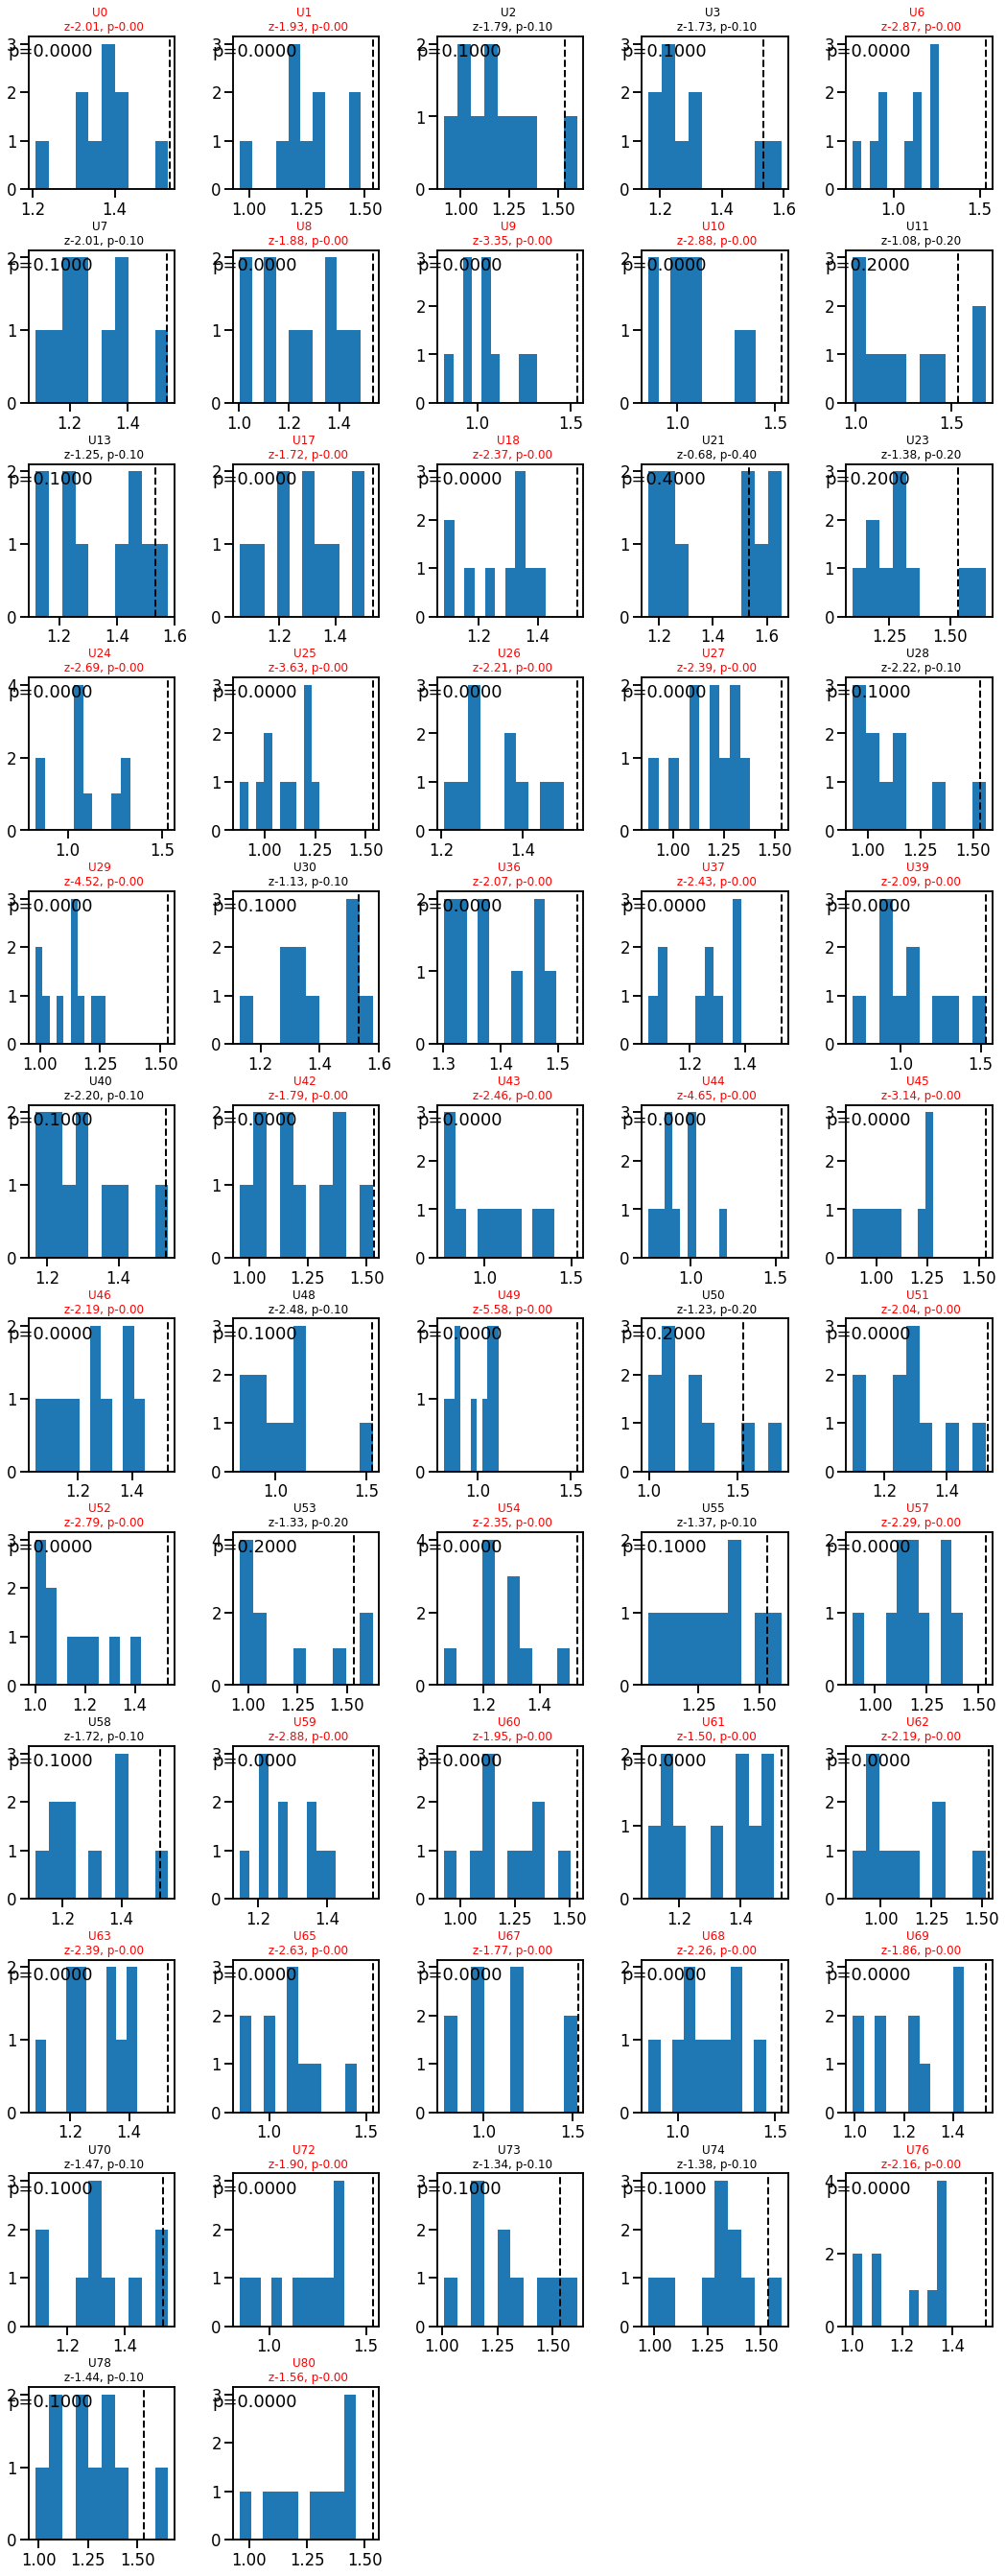

In [53]:
# OLD:
for ii, ax in zip(keep_inds, make_axes(n_keep, hspace=0.4, wspace=0.4)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii)
    times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, shuffle_min=20000) 
    surrogates = []

    for i, j in enumerate (times_shuffle):
        target_bins_1d = np.zeros([n_trials, n_bins])

        for t_ind in range(n_trials):
            
            t_st = nav_starts[t_ind]
            ch_openings = chest_openings[t_ind]
            t_en = ch_openings[-1]

            t_mask = chest_trials == t_ind

            t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
            ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

            t_spikes = restrict_range(times_shuffle[i], t_st, t_en)
            t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

            seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
            count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
            count.update(np.digitize(t_spikes, ch_openings))

            frs = np.array(list(count.values())) / seg_times

            cur_ch_xbin = ch_xbin[t_mask]
            cur_ch_ybin = ch_ybin[t_mask]

            target_bins = np.zeros(chest_bins)
            
            for fr, xbin, ybin in zip(frs, cur_ch_xbin, cur_ch_ybin):
                target_bins[xbin, ybin] = fr

            target_bins_1d[t_ind,:] = target_bins.flatten()

        target_bins_trial=target_bins_1d.flatten()

        target_bin_label = np.array(range(0, n_bins))
        target_bin_label = np.tile(target_bin_label,n_trials)

        merged_array = np.transpose(np.vstack([target_bin_label,target_bins_trial]))
        df = pd.DataFrame(merged_array,columns=['target_bin', 'fr'])

        model = smf.ols('fr ~ C(target_bin)', data=df).fit()
        aov_table = anova_lm(model, typ=2)
        f_val_surrs = aov_table['F']['C(target_bin)']

        surrogates.append(f_val_surrs)
        
    # Compute the empirical p-value based on surrogates
    surr_p_val = compute_empirical_pvalue(f_val, surrogates)

    # Compute z-score of the real F-value compared to surrogates
    z_score = zscore_to_surrogates(f_val, surrogates)

    # Plot the distribution of surrogates, comparing to real F-value
    plot_surrogates(surrogates, f_val, surr_p_val, ax=ax)
    
    color = 'red' if surr_p_val < 0.05 else 'black'
    title = 'U{} \n z-{:1.2f}, p-{:1.2f}'.format(ii, z_score, surr_p_val)
    ax.set_title(title, fontdict={'fontsize' : 12}, color=color)

In [54]:
n_surrogates = 10
set_random_seed(101)

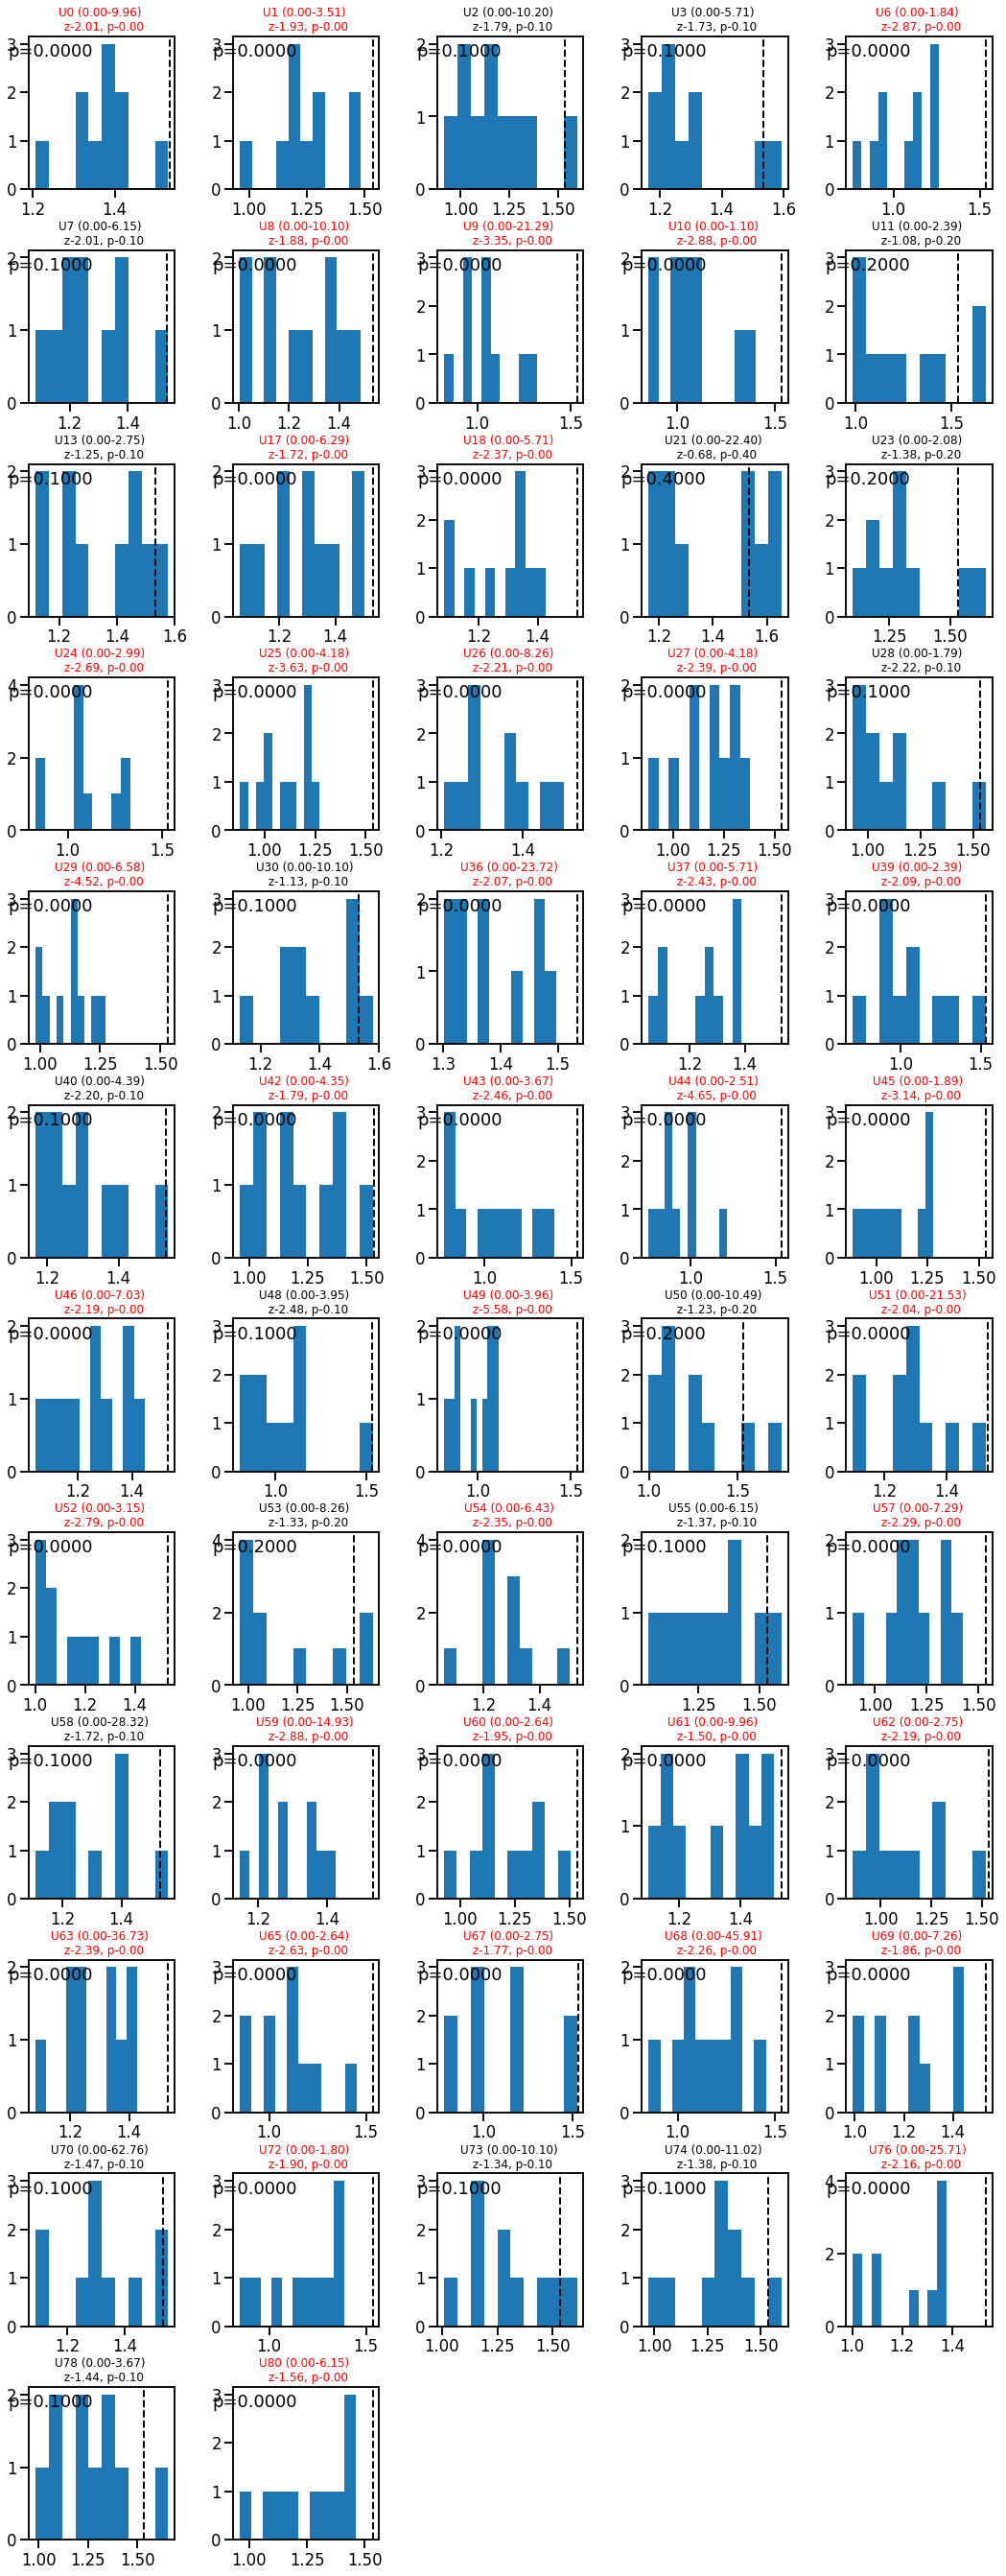

In [55]:
for ii, ax in zip(keep_inds, make_axes(n_keep, hspace=0.4, wspace=0.4)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii)
    times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

    surrogates = np.zeros(n_surrogates)
    for ind, shuffle in enumerate(times_shuffle):

        data = get_trial_target(shuffle, nav_starts, chest_bins, chest_openings,
                                chest_trials, ch_xbin, ch_ybin, ptimes, positions)
        df = create_df_target(data)
        surrogates[ind] = fit_anova_target(df)
    
    p_val, z_score = compute_surrogate_stats(f_val, surrogates, plot=True, verbose=False, ax=ax)
    
    target_bins = compute_spatial_target_bins(spikes, nav_starts, chest_openings, chest_trials, 
                                              ptimes, positions, chest_bins, ch_xbin, ch_ybin)
    #plot_heatmap(target_bins, transpose=True, ax=ax) 

    minb, maxb = np.min(target_bins), np.max(target_bins)
    ax.set_title('U{} ({:1.2f}-{:1.2f}) \n z-{:1.2f}, p-{:1.2f}'.format(ii, minb, maxb, z_score, p_val),
                 fontdict={'fontsize' : 12}, color=color_pval(p_val))